# Model Tuning and Results


When building and testing models for real-world use, we should choose model performance metrics based on the goal and usage of the model. In our case, we will be focusing on a high precision bar where the positive outcome is a fully paid off loan and then maximizing the total number of true positives. 
<br>
We have chosen to limit ourselves to decision tree-based algorithms because they are flexible and apply to broad types of data. We have some important ordinal variables in our dataset, including loan subgrade.


**Imports and Loading Data**

In [0]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For Colab
import os

#Google Collab Only
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)


In [0]:
clean_df = pd.read_pickle('/content/gdrive/My Drive/Lending Club Project/data/Pickle/clean_df_Mon.pkl').sample(frac=.10, random_state=0)

In [0]:
#clean_df = pd.read_pickle('./data/Pickle/clean_df.pkl').sample(frac=.10, random_state=0)

print(clean_df.shape)
outcome='fully_paid'

# split into train and validation sets
data_train, data_val = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);

X_train = data_train.drop(columns=['issue_d', 'zip_code', 'addr_state', outcome])
y_train = data_train[outcome]

X_val = data_val.drop(columns=['issue_d', 'zip_code', 'addr_state', outcome])
y_val = data_val[outcome]

(108744, 87)


## <font color='maroon'>Baseline Models</font>

Since we have performed feature selection using Random Forest, we will use a **single Decision Tree as our baseline with the top 15 features chosen by feature importances.**

First, for comparison purposes, we compute an accuracy score from a trival model: a model in which we simply predict all loans to have the outcome of the most-common class (i.e., predicting all loans to be fully paid).

In [0]:
# these are the features ordered by random forest feature
importances = ['int_rate', 'sub_grade', 'dti', 'installment', 'avg_cur_bal', 'credit_line_age', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'annual_inc', 'mo_sin_old_il_acct', 'tot_hi_cred_lim', 'revol_util', 'bc_util', 'revol_bal', 'tot_cur_bal', 'total_rev_hi_lim', 'total_bal_ex_mort', 'total_bc_limit', 'loan_amnt', 'total_il_high_credit_limit', 'grade', 'mths_since_recent_bc', 'total_acc', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_il_tl', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'num_bc_tl', 'acc_open_past_24mths', 'num_sats', 'open_acc', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'mths_since_last_delinq', 'percent_bc_gt_75', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'num_bc_sats', 'num_tl_op_past_12m', 'term_ 60 months', 'num_actv_bc_tl', 'mths_since_recent_revol_delinq', 'mort_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'mths_since_recent_bc_dlq', 'mths_since_last_record', 'inq_last_6mths', 'num_accts_ever_120_pd', 'delinq_2yrs', 'pub_rec', 'verification_status_Verified', 'verification_status_Source Verified', 'emp_length_10+ years', 'purpose_debt_consolidation', 'emp_length_5-9 years', 'emp_length_2-4 years', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'purpose_credit_card', 'pub_rec_bankruptcies', 'home_ownership_OWN', 'num_tl_90g_dpd_24m', 'tax_liens', 'purpose_home_improvement', 'purpose_other', 'collections_12_mths_ex_med', 'purpose_major_purchase', 'purpose_small_business', 'purpose_medical', 'application_type_Joint App', 'purpose_moving', 'chargeoff_within_12_mths', 'delinq_amnt', 'purpose_vacation', 'purpose_house', 'acc_now_delinq', 'purpose_wedding', 'purpose_renewable_energy', 'home_ownership_OTHER', 'home_ownership_NONE', 'purpose_educational']

In [0]:
top_15_features = importances[:15]

**For the purposes of our baseline model, we simply select the top 15 features from the random forest feature importances. We train and compare decison trees using this subset of features. **

**In subsequent models, we will engineer new features and carefully tune the subset of features to include.**


In [0]:
most_common_class = data_train[outcome].value_counts().idxmax()

## training set baseline accuracy
baseline_accuracy = np.sum(data_train[outcome]==most_common_class)/len(data_train)

print("Classification accuracy (training set) if we predict all loans to be fully paid: {:.3f}"
      .format(baseline_accuracy))

Classification accuracy (training set) if we predict all loans to be fully paid: 0.799


Now we train our baseline models on the subset of features. For baseline models we simply use the default DecisionTreeClassifier (which uses class_weights=None), trained on max_depths from 2 to 10. 

We store various performance metrics; in addition to the accuracy score, we also store the balanced accuracy score, precision score, and confusion matrix for each model so that we can investigate beyond a simple accuracy score.

In [0]:
# Subset to top features 
data_train_baseline = data_train[top_15_features+[outcome]]
data_val_baseline = data_val[top_15_features+[outcome]]


In [0]:
# Compare baseline models: Decision trees of depth 2 to 20

def compare_tree_models(data_train, data_val, outcome, class_weights=[None], max_depths=range(2,21)):
    X_train = data_train.drop(columns=outcome)
    y_train = data_train[outcome]
    X_val = data_val.drop(columns=outcome)
    y_val = data_val[outcome]

    results_list = []
    for class_weight in class_weights:
        for depth in max_depths:
            clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, class_weight=class_weight)
            clf.fit(X_train, y_train)

            y_train_pred = clf.predict(X_train)
            y_val_pred = clf.predict(X_val)

            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
            train_precision = precision_score(y_train, y_train_pred)
            train_cm = confusion_matrix(y_train, y_train_pred)

            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred)
            val_cm = confusion_matrix(y_val, y_val_pred)

            results_list.append({'Depth': depth,
                                    'class_weight': class_weight,
                                    'Train Accuracy': train_accuracy,
                                    'Train Balanced Accuracy': train_balanced_accuracy,
                                    'Train Precision': train_precision,
                                    'Train CM': train_cm,
                                    'Val Accuracy': val_accuracy,
                                    'Val Balanced Accuracy': val_balanced_accuracy,
                                    'Val Precision': val_precision,
                                    'Val CM': val_cm})
            
    columns=['Depth', 'class_weight', 'Train Accuracy', 'Train Balanced Accuracy',
    'Train Precision', 'Val Accuracy', 'Val Balanced Accuracy', 'Val Precision']
        
    results_table = pd.DataFrame(results_list, columns=columns)
    return results_table, results_list

results_table, results_list = compare_tree_models(data_train_baseline, data_val_baseline, outcome='fully_paid')
results_table

,Depth,class_weight,Train Accuracy,Train Balanced Accuracy,Train Precision,Val Accuracy,Val Balanced Accuracy,Val Precision
0,2,None,0.799313,0.500000,0.799313,0.799356,0.500000,0.799356
1,3,None,0.799313,0.500000,0.799313,0.799356,0.500000,0.799356
2,4,None,0.799487,0.536238,0.811405,0.800828,0.539709,0.812626
3,5,None,0.801163,0.530861,0.809520,0.800276,0.532327,0.810081
4,6,None,0.801561,0.516372,0.804640,0.800276,0.516537,0.804748
5,7,None,0.802409,0.533414,0.810372,0.799632,0.531752,0.809895
6,8,None,0.804892,0.532469,0.810003,0.798529,0.527458,0.808444
7,9,None,0.807804,0.542317,0.813327,0.796046,0.528136,0.808716
8,10,None,0.812607,0.555445,0.817789,0.790437,0.526687,0.808306
9,11,None,0.818492,0.579222,0.826148,0.786943,0.532911,0.810540


In [0]:
# print_confusion_matrix function taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

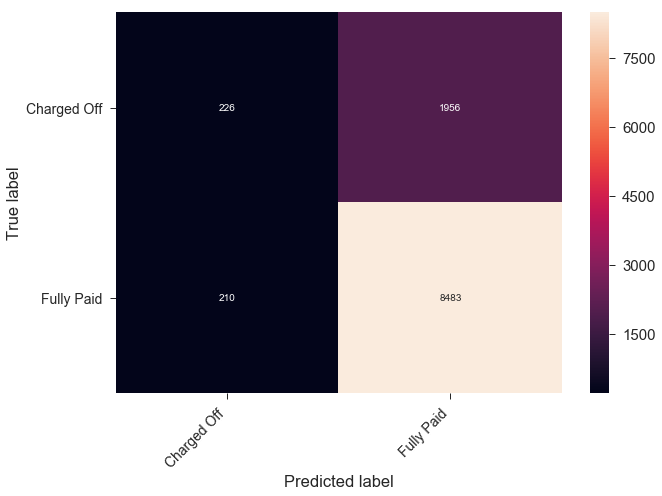

In [0]:
# Select model with best validation accuracy score and plot its confusion matrix
best_model_index = results_table['Val Accuracy'].idxmax()
cm = results_list[best_model_index]['Val CM']

fig = print_confusion_matrix(cm, class_names=['Charged Off', 'Fully Paid'])


Comments: Our baseline accuracy values are not impressive; the best accuracy score on the validation set is about 80%, which is the accuracy we'd achieve if we simply predicted all loans to be fully paid.

Though we have used accuracy as the scoring metric for our baseline model, we realize that this is not the most appropriate metric to use going forward. We should also consider other performance metrics, such as precision scores and balanced accuracy scores.

Going forward, we should also place more weight (i.e., by modifyinng the `class_weight` when training models) on correctly classifying loans that are charged off. There are two main reasons for this:
1. 80% of the loans in our dataset are, in fact, fully paid. We should add more weight to the charged-off loans to account for this imbalance in the loan outcome labels.
2. For the purposes of building a sound, reasonably low-risk investment strategy, we hope to minimize the particular error in which the model predicts a loan to be fully paid when it is truly charged off. We will tune the class_weight parameter in future models to select an optimal value for our purposes.


## <font color='maroon'>Feature Engineering Attempts</font>

To enhance model performance while tuning our models, , we explored generating additional features not in the raw data set to potentially catch additional relationships in the response variable. 

Our attempts included interaction variables between top features, as well as polynomial terms with degree 2. Unfortunately, we did not see any notable model performance from these changes, so they were not included in our final model. 

There are many other higher-order polynomial and interaction terms and combinations of relevant/related predictors that could also be fine-tuned into better summary variables to boost model performance. This feature engineering step is an area where there is room for substantial improvement upon our model in the future. 

In [0]:
def sum_cols_to_new_feature(df, new_feature_name, cols_to_sum, drop=True):
    new_df = df.copy()
    new_df[new_feature_name] = 0
    for col in cols_to_sum:
        new_df[new_feature_name] = new_df[new_feature_name] + new_df[col]
    if drop:
        new_df = new_df.drop(columns=cols_to_sum)
    return new_df

# engineer features
def add_interactions(loandf):
    df = loandf.copy()
    df['int_rate_X_sub_grade'] = df['int_rate']*df['sub_grade']
    df['installment_X_sub_grade'] = df['installment']*df['sub_grade']
    df['installment_X_int_rate'] = df['installment']*df['int_rate']
    df['int_rate_X_sub_grade_X_installment'] = df['int_rate']*df['sub_grade']*df['installment']
    df['dti_X_sub_grade'] = df['dti']*df['sub_grade']
    df['mo_sin_old_rev_tl_op_X_sub_grade'] = df['mo_sin_old_rev_tl_op']*df['sub_grade']
    df['dti_X_mo_sin_old_rev_tl_op_X_sub_grade'] = df['dti']*df['mo_sin_old_rev_tl_op']*df['sub_grade']
    df['income_to_loan_amount'] = df['annual_inc']/df['loan_amnt']
    df['dti_X_income'] = df['dti']*df['annual_inc']
    df['dti_X_income_X_loan_amnt'] = df['annual_inc']*df['loan_amnt']*df['dti']
    df['dti_X_loan_amnt'] = df['dti']*df['loan_amnt']
    df['avg_cur_bal_X_dti'] = df['avg_cur_bal']*df['dti']
    
    return df



In [0]:
outcome='fully_paid'
#clean_df = pd.read_pickle('./data/Pickle/clean_df.pkl').sample(frac=0.05, random_state=0)
clean_df = pd.read_pickle('/content/gdrive/My Drive/Lending Club Project/data/Pickle/clean_df_Mon.pkl').sample(frac=.05, random_state=0)


clean_df = add_interactions(clean_df)
# months since delinquencies, summed
clean_df = sum_cols_to_new_feature(clean_df, new_feature_name='months_since_delinq_combined',
            cols_to_sum=['mths_since_last_delinq', 'mths_since_last_major_derog','mths_since_last_record',
            'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq'], drop=True)

# number of bad records
clean_df = sum_cols_to_new_feature(clean_df, new_feature_name='num_bad_records',
            cols_to_sum=['num_accts_ever_120_pd','num_tl_90g_dpd_24m','pub_rec',
                         'pub_rec_bankruptcies', 'tax_liens'], drop=True)
# combined credit limit
clean_df = sum_cols_to_new_feature(clean_df, new_feature_name='combined_credit_lim',
            cols_to_sum=['tot_hi_cred_lim','total_bc_limit','total_il_high_credit_limit',
                         'total_rev_hi_lim',], drop=True)

# number of recent delinquencies
clean_df = sum_cols_to_new_feature(clean_df, new_feature_name='num_recent_delinq',
            cols_to_sum=['delinq_2yrs', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med'], drop=True)

# number of accounts
clean_df = sum_cols_to_new_feature(clean_df, new_feature_name='num_accounts',
            cols_to_sum=['num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                         'num_actv_rev_tl', 'num_actv_bc_tl', 'mort_acc'], drop=True)
                         

clean_df = clean_df.drop(columns = ['issue_d', 'zip_code', 'addr_state'])
data_train, data_test = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);

X_train = data_train.drop(columns=outcome)
y_train = data_train[outcome]
rf_model = RandomForestClassifier(n_estimators=50, max_depth=50).fit(X_train, y_train)
                         
importances = pd.DataFrame({'Columns':X_train.columns,'Feature_Importances':rf_model.feature_importances_})
importances = importances.sort_values(by='Feature_Importances',ascending=False)
print(importances['Columns'].values.tolist()[:15])

['dti_X_sub_grade', 'int_rate', 'int_rate_X_sub_grade_X_installment', 'int_rate_X_sub_grade', 'dti_X_mo_sin_old_rev_tl_op_X_sub_grade', 'dti', 'income_to_loan_amount', 'avg_cur_bal', 'dti_X_loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op_X_sub_grade', 'bc_open_to_buy', 'installment_X_sub_grade', 'sub_grade', 'revol_bal']


In [0]:
# Compare baseline models: Decision trees of depth 2 to 20

def compare_tree_models(data_train, data_val, outcome, class_weights=[None], max_depths=range(2,21)):
    X_train = data_train.drop(columns=outcome)
    y_train = data_train[outcome]
    X_val = data_val.drop(columns=outcome)
    y_val = data_val[outcome]

    tree_results = []
    for class_weight in class_weights:
        for depth in max_depths:
            clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, class_weight=class_weight)
            clf.fit(X_train, y_train)

            y_train_pred = clf.predict(X_train)
            y_val_pred = clf.predict(X_val)

            train_accuracy = accuracy_score(y_train, y_train_pred)
            train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
            train_precision = precision_score(y_train, y_train_pred)
            train_cm = confusion_matrix(y_train, y_train_pred)

            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
            val_precision = precision_score(y_val, y_val_pred)
            val_cm = confusion_matrix(y_val, y_val_pred)

            tree_results.append({'Depth': depth,
                                    'class_weight': class_weight,
                                    'Train Accuracy': train_accuracy,
                                    'Train Balanced Accuracy': train_balanced_accuracy,
                                    'Train Precision': train_precision,
                                    'Train CM': train_cm,
                                    'Val Accuracy': val_accuracy,
                                    'Val Balanced Accuracy': val_balanced_accuracy,
                                    'Val Precision': val_precision,
                                    'Val CM': val_cm})
    return tree_results


results = compare_tree_models(data_train, data_test,\
            outcome='fully_paid', class_weights=[None, 'balanced', {0:5, 1:1},{0:6, 1:1}, {0:7, 1:1}, {0:8, 1:1}])




In [0]:
columns=['Depth', 'class_weight', 'Train Accuracy','Train Precision', 'Val Accuracy','Val Precision']

scores_table = pd.DataFrame(results, columns=columns)

msk = scores_table['Val Precision'] >= 0.9
scores_table[msk].sort_values(by='Val Accuracy', ascending=False).head()

,Depth,class_weight,Train Accuracy,Train Precision,Val Accuracy,Val Precision
40,4,"{0: 5, 1: 1}",0.530919,0.908322,0.523170,0.902159
59,4,"{0: 6, 1: 1}",0.530919,0.908322,0.523170,0.902159
62,7,"{0: 6, 1: 1}",0.538950,0.921664,0.517286,0.900326
78,4,"{0: 7, 1: 1}",0.474292,0.917505,0.470394,0.914966
81,7,"{0: 7, 1: 1}",0.487657,0.932268,0.465612,0.904842
83,9,"{0: 7, 1: 1}",0.495504,0.954543,0.460280,0.906520
82,8,"{0: 7, 1: 1}",0.482609,0.943900,0.458073,0.903991
79,5,"{0: 7, 1: 1}",0.460804,0.922437,0.457705,0.917415
77,3,"{0: 7, 1: 1}",0.458843,0.918520,0.455866,0.914423
96,3,"{0: 8, 1: 1}",0.458843,0.918520,0.455866,0.914423


In [0]:
# Redoing without Engineered Features

clean_df = pd.read_pickle('/content/gdrive/My Drive/Lending Club Project/data/Pickle/clean_df_Mon.pkl').sample(frac=.05, random_state=0)
clean_df = clean_df.drop(columns = ['issue_d', 'zip_code', 'addr_state'])
data_train, data_test = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);

X_train = data_train.drop(columns=outcome)
y_train = data_train[outcome]

results = compare_tree_models(data_train, data_test,\
            outcome='fully_paid', class_weights=[None, 'balanced', {0:5, 1:1},{0:6, 1:1}, {0:7, 1:1}, {0:8, 1:1}])




In [0]:
columns=['Depth', 'class_weight', 'Train Accuracy','Train Precision', 'Val Accuracy','Val Precision']

scores_table = pd.DataFrame(results, columns=columns)

msk = scores_table['Val Precision'] >= 0.9
scores_table[msk].sort_values(by='Val Accuracy', ascending=False).head()

,Depth,class_weight,Train Accuracy,Train Precision,Val Accuracy,Val Precision
41,5,"{0: 5, 1: 1}",0.550170,0.905982,0.546157,0.900171
42,6,"{0: 5, 1: 1}",0.549413,0.910787,0.541192,0.901085
62,7,"{0: 6, 1: 1}",0.530613,0.922110,0.521883,0.900735
61,6,"{0: 6, 1: 1}",0.525259,0.916513,0.520780,0.905317
60,5,"{0: 6, 1: 1}",0.519434,0.912385,0.516182,0.905732


In [0]:
# use top features from random forest importances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train = data_train.drop(columns=outcome)
y_train = data_train[outcome]
X_val = data_test.drop(columns=outcome)
y_val = data_test[outcome]

scores = []
for i in range(2,11):
    print(i)
    clf = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                            DecisionTreeClassifier(criterion='gini', max_depth=i,
                            class_weight={0:5, 1:1}))

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)

    scores.append({'Depth': i,
                            'Train Accuracy': train_accuracy,
                            'Train Balanced Accuracy': train_balanced_accuracy,
                            'Train Precision': train_precision,
                            'Val Accuracy': val_accuracy,
                            'Val Balanced Accuracy': val_balanced_accuracy,
                            'Val Precision': val_precision,})

    clear_output()
        
columns=['Depth', 'Train Accuracy','Train Precision', 'Val Accuracy','Val Precision']
scores_table = pd.DataFrame(scores, columns=columns)
msk = scores_table['Val Precision'] >= 0.9
scores_table[msk].sort_values(by='Val Accuracy', ascending=False).head()

,Depth,Train Accuracy,Train Precision,Val Accuracy,Val Precision


In [0]:
scores_table.sort_values(by='Val Precision', ascending=False).head()

,Depth,Train Accuracy,Train Precision,Val Accuracy,Val Precision
0,2,0.520517,0.905729,0.514160,0.899906
1,3,0.520517,0.905729,0.514160,0.899906
4,6,0.590060,0.907898,0.584038,0.894917
3,5,0.579168,0.903548,0.574476,0.894328
5,7,0.604753,0.911508,0.587900,0.890167


## <font color='maroon'>Decision Tree Model Tuning/Comparison</font>


In [0]:
clean_df = pd.read_pickle('/content/gdrive/My Drive/Lending Club Project/data/Pickle/clean_df_Mon.pkl').sample(frac=.05, random_state=0)

outcome='fully_paid'

data_train, data_test = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);
print(data_train.shape, data_test.shape)
data_train, data_val = train_test_split(data_train, test_size=.2, stratify=data_train[outcome], random_state=99)
print(data_train.shape, data_val.shape)

X_train = data_train.drop(columns=['issue_d', 'zip_code', 'addr_state', outcome])
y_train = data_train[outcome]

# Feature importances from RF
importances = ['int_rate', 'sub_grade', 'dti', 'installment', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'bc_open_to_buy', 'credit_line_age', 'tot_hi_cred_lim', 'annual_inc', 'revol_util', 'bc_util', 'mo_sin_old_il_acct', 'revol_bal', 'total_rev_hi_lim', 'total_bc_limit', 'tot_cur_bal', 'total_bal_ex_mort', 'loan_amnt', 'total_il_high_credit_limit', 'mths_since_recent_bc', 'total_acc', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_il_tl', 'grade', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'num_bc_tl', 'acc_open_past_24mths', 'open_acc', 'num_sats', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'mths_since_last_delinq', 'percent_bc_gt_75', 'term_ 60 months', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats', 'num_actv_bc_tl', 'num_tl_op_past_12m', 'mths_since_recent_revol_delinq', 'mort_acc', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'tot_coll_amt', 'mths_since_last_record', 'inq_last_6mths', 'num_accts_ever_120_pd', 'delinq_2yrs', 'pub_rec', 'verification_status_Verified', 'verification_status_Source Verified', 'emp_length_10+ years', 'purpose_debt_consolidation', 'emp_length_5-9 years', 'emp_length_2-4 years', 'home_ownership_RENT', 'purpose_credit_card', 'pub_rec_bankruptcies', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'num_tl_90g_dpd_24m', 'tax_liens', 'purpose_other', 'purpose_home_improvement', 'collections_12_mths_ex_med', 'purpose_major_purchase', 'purpose_small_business', 'purpose_medical', 'application_type_Joint App', 'purpose_moving', 'chargeoff_within_12_mths', 'purpose_vacation', 'delinq_amnt', 'purpose_house', 'acc_now_delinq', 'purpose_renewable_energy', 'purpose_wedding', 'home_ownership_OTHER', 'home_ownership_NONE', 'purpose_educational']

(48934, 87) (5438, 87)
(39147, 87) (9787, 87)


In [0]:
scores = []
features = []
for column in importances:
    features.append(column)
    print(features)
    clear_output()
    print(features)

    print(len(features))

    X_train = data_train[features]
    y_train = data_train[outcome]

    X_val = data_val[features]
    y_val = data_val[outcome]  

    X_test = data_test[features]
    y_test = data_test[outcome]  
    

    for depth in range(3,10):
      for weight in range (3, 8):
        rf_tmp = DecisionTreeClassifier(max_depth=depth, class_weight={0:weight, 1:1}).fit(X_train, y_train)

        y_train_pred = rf_tmp.predict(X_train)
        y_val_pred = rf_tmp.predict(X_val)
        y_test_pred = rf_tmp.predict(X_test)    

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        
        test_accuracy = accuracy_score(y_test,y_test_pred)  
        test_balanced_accuracy = balanced_accuracy_score(y_test,y_test_pred)
        test_precision = precision_score(y_test,y_test_pred)  
        
        val_accuracy = accuracy_score(y_val,y_val_pred)   
        val_balanced_accuracy = balanced_accuracy_score(y_val,y_val_pred)
        val_precision = precision_score(y_val,y_val_pred) 

        tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
        train_approved = tp
        
        tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred).ravel()
        test_approved = tp
        
        tn, fp, fn, tp = confusion_matrix(y_val,y_val_pred).ravel()  
        val_approved = tp

        scores.append({'Top_N_Features': len(features),
                       'Depth': depth,
                       'Weight': rf_tmp.get_params()['class_weight'],
                       'Test Accuracy': test_accuracy,
                       'Test Balanced Accuracy': test_balanced_accuracy,
                       'Test Precision': test_precision,
                       'Test Fully Paid Loans': test_approved,
                       
                       'Val Accuracy': val_accuracy,
                       'Val Balanced Accuracy': val_balanced_accuracy,
                       'Val Precision': val_precision,
                       'Val Fully Paid Loans': val_approved,
                       
                       'Train Accuracy': train_accuracy,
                       'Train Balanced Accuracy': train_balanced_accuracy,
                       'Train Precision': train_precision,
                       'Train Fully Paid Loans': train_approved,
                     
                      })
table_col_names = ['Top_N_Features','Depth','Weight', 'Test Accuracy', 'Test Balanced Accuracy','Test Precision','Test Fully Paid Loans',
'Val Accuracy','Val Balanced Accuracy','Val Precision','Val Fully Paid Loans','Train Accuracy','Train Balanced Accuracy',
'Train Precision','Train Fully Paid Loans']

tree_scores = pd.DataFrame(scores)
tree_scores = tree_scores[table_col_names]

In [0]:
# Save the model results to access/compare later
path = '/content/gdrive/My Drive/Lending Club Project/data/Victor/'
#tree_scores.to_csv(path+'tree_scores.csv',index=False)
tree_scores = pd.read_csv(path+'tree_scores.csv')
tree_scores[(tree_scores['Val Precision']>=0.9)&(tree_scores['Test Precision']>=0.9)].sort_values('Val Fully Paid Loans',ascending=False).head()


,Top_N_Features,Depth,Weight,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Fully Paid Loans,Val Accuracy,Val Balanced Accuracy,Val Precision,Val Fully Paid Loans,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Fully Paid Loans
467,14,5,"{0: 5, 1: 1}",0.533468,0.631052,0.90031,2032,0.538469,0.634381,0.901655,3704,0.541344,0.641536,0.907904,14817
432,13,5,"{0: 5, 1: 1}",0.533468,0.631052,0.90031,2032,0.538469,0.634381,0.901655,3704,0.541344,0.641536,0.907904,14817
572,17,5,"{0: 5, 1: 1}",0.533468,0.631052,0.90031,2032,0.538469,0.634381,0.901655,3704,0.541344,0.641536,0.907904,14817
502,15,5,"{0: 5, 1: 1}",0.533468,0.631052,0.90031,2032,0.538469,0.634381,0.901655,3704,0.541344,0.641536,0.907904,14817
607,18,5,"{0: 5, 1: 1}",0.533468,0.631052,0.90031,2032,0.538469,0.634381,0.901655,3704,0.541344,0.641536,0.907904,14817


## <font color='maroon'>Random Forest Model Tuning/Comparison</font>


In [0]:
rf_scores = []
features = []
for column in importances[:20]:
    features.append(column)
    clear_output()
    #print(len(features))
    print(features)


    X_train = data_train[features]
    print(X_train.shape)
    y_train = data_train[outcome]

    X_val = data_val[features]
    y_val = data_val[outcome]  

    X_test = data_test[features]
    y_test = data_test[outcome]  
    

    for depth in range(3,10):
      for weight in range (3, 8):
        #rf_tmp = DecisionTreeClassifier(max_depth=depth, class_weight={0:weight, 1:1}).fit(X_train, y_train)
        rf_tmp = RandomForestClassifier(n_estimators=20, max_depth=depth, class_weight={0:weight, 1:1}).fit(X_train, y_train)
        print(X_train.shape, X_train.columns)
        
        y_train_pred = rf_tmp.predict(X_train)
        y_val_pred = rf_tmp.predict(X_val)
        y_test_pred = rf_tmp.predict(X_test)    

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred)
        
        test_accuracy = accuracy_score(y_test,y_test_pred)  
        test_balanced_accuracy = balanced_accuracy_score(y_test,y_test_pred)
        test_precision = precision_score(y_test,y_test_pred)  
        
        val_accuracy = accuracy_score(y_val,y_val_pred)   
        val_balanced_accuracy = balanced_accuracy_score(y_val,y_val_pred)
        val_precision = precision_score(y_val,y_val_pred) 

        tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
        train_approved = tp
        
        tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred).ravel()
        test_approved = tp
        
        tn, fp, fn, tp = confusion_matrix(y_val,y_val_pred).ravel()  
        val_approved = tp

        rf_scores.append({'Top_N_Features': len(features),
                       'Depth': depth,
                       'Weight': rf_tmp.get_params()['class_weight'],
                       'Test Accuracy': test_accuracy,
                       'Test Balanced Accuracy': test_balanced_accuracy,
                       'Test Precision': test_precision,
                       'Test Fully Paid Loans': test_approved,
                       
                       'Val Accuracy': val_accuracy,
                       'Val Balanced Accuracy': val_balanced_accuracy,
                       'Val Precision': val_precision,
                       'Val Fully Paid Loans': val_approved,
                       
                       'Train Accuracy': train_accuracy,
                       'Train Balanced Accuracy': train_balanced_accuracy,
                       'Train Precision': train_precision,
                       'Train Fully Paid Loans': train_approved,
                     
                      })
        
table_col_names = ['Top_N_Features','Depth','Weight', 'Test Accuracy', 'Test Balanced Accuracy','Test Precision','Test Fully Paid Loans',
'Val Accuracy','Val Balanced Accuracy','Val Precision','Val Fully Paid Loans','Train Accuracy','Train Balanced Accuracy',
'Train Precision','Train Fully Paid Loans']

rf_scores = pd.DataFrame(rf_scores)
rf_scores = rf_scores[table_col_names]


In [0]:
# Store results to CSV file
path = '/content/gdrive/My Drive/Lending Club Project/data/Victor/'
#rf_scores.to_csv(path+'rf_scores.csv',index=False)
rf_scores = pd.read_csv(path+'rf_scores.csv')
rf_scores[(rf_scores['Val Precision']>=0.9)&(rf_scores['Test Precision']>=0.9)].sort_values('Val Fully Paid Loans',ascending=False).head()

,Top_N_Features,Depth,Weight,Test Accuracy,Test Balanced Accuracy,Test Precision,Test Fully Paid Loans,Val Accuracy,Val Balanced Accuracy,Val Precision,Val Fully Paid Loans,Train Accuracy,Train Balanced Accuracy,Train Precision,Train Fully Paid Loans
1498,43,8,"{0: 6, 1: 1}",0.549834,0.637193,0.900000,2133,0.553387,0.638784,0.900139,3876,0.577081,0.679289,0.930936,15892
1307,38,5,"{0: 5, 1: 1}",0.548915,0.636959,0.900127,2127,0.552978,0.639478,0.900979,3867,0.557616,0.647306,0.906901,15547
1323,38,8,"{0: 6, 1: 1}",0.548547,0.638097,0.901402,2121,0.552774,0.639350,0.900932,3865,0.578461,0.681102,0.932163,15926
588,17,8,"{0: 6, 1: 1}",0.548731,0.637870,0.901104,2123,0.551957,0.639218,0.901122,3855,0.570925,0.675008,0.929487,15660
1638,47,8,"{0: 6, 1: 1}",0.549283,0.638557,0.901570,2125,0.552570,0.641310,0.902954,3852,0.577362,0.681269,0.932906,15865


## <font color='maroon'>Comparison of Top Decision Tree vs. Top Random Forest Models</font>


In [0]:
clean_df = pd.read_pickle('/content/gdrive/My Drive/Lending Club Project/data/Pickle/clean_df_Mon.pkl')

print('Total Number of Rows:', '{:,}'.format(clean_df.shape[0]))
print('Total Number of Columns:', '{:,}'.format(clean_df.shape[1]))

Total Number of Rows: 1,087,436
Total Number of Columns: 87


In [0]:
# Subset to top features 
outcome='fully_paid'

data_train, data_test = train_test_split(clean_df, test_size=.1, stratify=clean_df[outcome], random_state=99);
print(data_train.shape, data_test.shape)
data_train, data_val = train_test_split(data_train, test_size=.2, stratify=data_train[outcome], random_state=99)
print(data_train.shape, data_val.shape)

(978692, 87) (108744, 87)
(782953, 87) (195739, 87)


In [0]:
importances = ['int_rate', 'sub_grade', 'dti', 'installment', 'avg_cur_bal', 'mo_sin_old_rev_tl_op', 'bc_open_to_buy', 'credit_line_age', 'tot_hi_cred_lim', 'annual_inc', 'revol_util', 'bc_util', 'mo_sin_old_il_acct', 'revol_bal', 'total_rev_hi_lim', 'total_bc_limit', 'tot_cur_bal', 'total_bal_ex_mort', 'loan_amnt', 'total_il_high_credit_limit', 'mths_since_recent_bc', 'total_acc', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'num_il_tl', 'grade', 'mths_since_recent_inq', 'mo_sin_rcnt_tl', 'num_bc_tl', 'acc_open_past_24mths', 'open_acc', 'num_sats', 'pct_tl_nvr_dlq', 'num_op_rev_tl', 'mths_since_last_delinq', 'percent_bc_gt_75', 'term_ 60 months', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats', 'num_actv_bc_tl', 'num_tl_op_past_12m', 'mths_since_recent_revol_delinq', 'mort_acc', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'tot_coll_amt', 'mths_since_last_record', 'inq_last_6mths', 'num_accts_ever_120_pd', 'delinq_2yrs', 'pub_rec', 'verification_status_Verified', 'verification_status_Source Verified', 'emp_length_10+ years', 'purpose_debt_consolidation', 'emp_length_5-9 years', 'emp_length_2-4 years', 'home_ownership_RENT', 'purpose_credit_card', 'pub_rec_bankruptcies', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'num_tl_90g_dpd_24m', 'tax_liens', 'purpose_other', 'purpose_home_improvement', 'collections_12_mths_ex_med', 'purpose_major_purchase', 'purpose_small_business', 'purpose_medical', 'application_type_Joint App', 'purpose_moving', 'chargeoff_within_12_mths', 'purpose_vacation', 'delinq_amnt', 'purpose_house', 'acc_now_delinq', 'purpose_renewable_energy', 'purpose_wedding', 'home_ownership_OTHER', 'home_ownership_NONE', 'purpose_educational']

In [0]:
features = importances[0:43]
depth = 8
weight = 6

X_train = data_train[features]
y_train = data_train[outcome]

X_val = data_val[features]
y_val = data_val[outcome]  

X_test = data_test[features]
y_test = data_test[outcome]  
    
rf_model = RandomForestClassifier(n_estimators=50, max_depth=depth, class_weight={0:weight, 1:1}).fit(X_train, y_train)


rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, class_weight={0:6, 1:1}).fit(X_train, y_train)


In [0]:
data_test['RF_Model_Prediction'] = rf_model.predict(X_test) 
data_test['RF_Probability_Fully_Paid'] = rf_model.predict_proba(X_test)[:,1]


In [0]:
features = importances[0:13]
depth = 5
weight = 5

X_train = data_train[features]
y_train = data_train[outcome]

X_val = data_val[features]
y_val = data_val[outcome]  

X_test = data_test[features]
y_test = data_test[outcome]  
    
rf_model = DecisionTreeClassifier(max_depth=depth, class_weight={0:weight, 1:1}).fit(X_train, y_train)


In [0]:
data_test['Tree_Model_Prediction'] = rf_model.predict(X_test) 
data_test['Tree_Probability_Fully_Paid'] = rf_model.predict_proba(X_test)[:,1]


In [0]:
data_test[['RF_Model_Prediction','Tree_Model_Prediction','RF_Probability_Fully_Paid','Tree_Probability_Fully_Paid']].describe()

,RF_Model_Prediction,Tree_Model_Prediction,RF_Probability_Fully_Paid,Tree_Probability_Fully_Paid
count,108744.000000,108744.000000,108744.000000,108744.000000
mean,0.366908,0.436806,0.447268,0.484344
std,0.481963,0.495993,0.167528,0.178238
min,0.000000,0.000000,0.124550,0.187470
25%,0.000000,0.000000,0.318232,0.357840
50%,0.000000,0.000000,0.421940,0.455652
75%,1.000000,1.000000,0.563963,0.616304
max,1.000000,1.000000,0.888068,0.864915


With similar total funded fully paid loans between the best Decision Tree and Random Forest, we need to look at the probability distributions. Because it is unrealistic to expect investors to invest in all loans we recommend, we will rank the loans by order of probability. As such, the performance of the models at predicting loans near 1.0 matters more than the loans near 0.5 as those will be fulfilled first. 

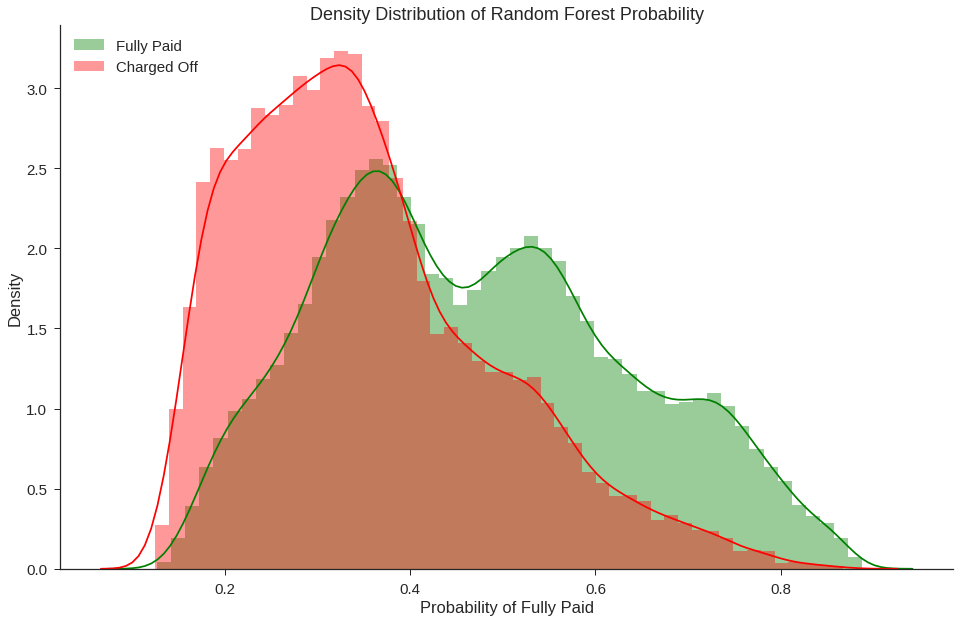

In [0]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(data_test[data_test['fully_paid']==1]['RF_Probability_Fully_Paid'],color='green',rug=False,label='Fully Paid')
sns.distplot(data_test[data_test['fully_paid']==0]['RF_Probability_Fully_Paid'],color='red',rug=False,label='Charged Off')

ax.set_title('Density Distribution of Random Forest Probability')
ax.set_xlabel('Probability of Fully Paid')
ax.set_ylabel('Density')
plt.legend(loc='upper left')

sns.despine()

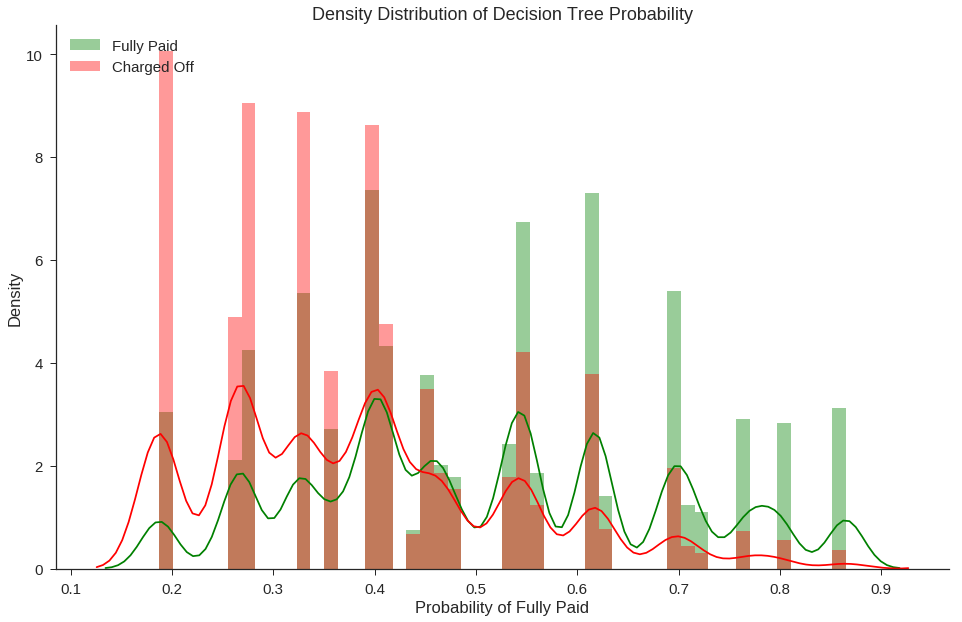

In [0]:
fig, ax = plt.subplots(figsize=(16,10))

sns.distplot(data_test[data_test['fully_paid']==1]['Tree_Probability_Fully_Paid'],color='green',rug=False,label='Fully Paid')
sns.distplot(data_test[data_test['fully_paid']==0]['Tree_Probability_Fully_Paid'],color='red',rug=False,label='Charged Off')


ax.set_title('Density Distribution of Decision Tree Probability')
ax.set_xlabel('Probability of Fully Paid')
ax.set_ylabel('Density')
plt.legend(loc='upper left')

sns.despine()

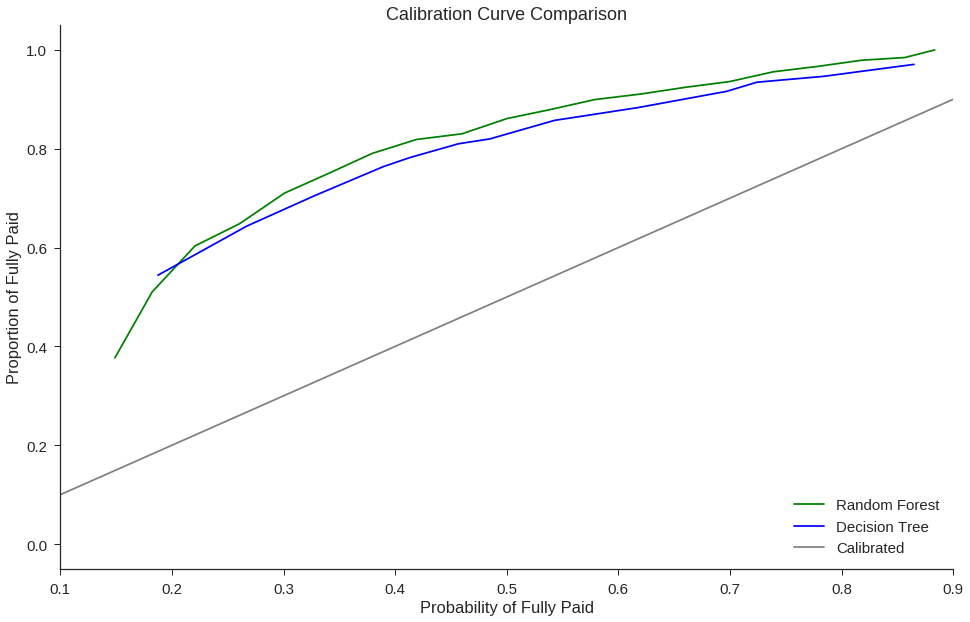

In [0]:
from sklearn.calibration import calibration_curve
rf_positive_frac, rf_mean_score = calibration_curve(y_test, data_test['RF_Probability_Fully_Paid'].values, n_bins=25)
tree_positive_frac, tree_mean_score = calibration_curve(y_test, data_test['Tree_Probability_Fully_Paid'].values, n_bins=25)

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(rf_mean_score,rf_positive_frac, color='green', label='Random Forest')
ax.plot(tree_mean_score,tree_positive_frac, color='blue', label='Decision Tree')
ax.plot([0, 1], [0, 1], color='grey', label='Calibrated')

ax.set_title('Calibration Curve Comparison')
ax.set_xlabel('Probability of Fully Paid')
ax.set_ylabel('Proportion of Fully Paid')
ax.set_xlim([.1, .9])
plt.legend(loc='lower right')

sns.despine()

Because we chose models with a high base precision, the calibration curve is not suprising. 
<br>Our use case will only focus on the upper end of the probability scores where an approved charged off loan is the worst misclasification so it is not a big issue that the probabilities are not 1:1 to the proportion of fully paid loans. What we see is that our chosen Random Forest model has higher proportion of fully paid loans in comparison to Decision Tree at high probability values. While the Decision Tree is more interpretable, Random Forest is a good balance between performance and interpretability.